In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from functools import reduce

import squarify as sq

import folium
from folium.plugins import HeatMap

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.cluster import KMeans

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

import urllib
from io import BytesIO 
import requests

import warnings
warnings.filterwarnings('ignore')

In [4]:
filesList = []

for dirname, _, filenames in os.walk('/Users/rohiththallapally/kaggle/input2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
       
        file = os.path.join(dirname, filename)
        fileExt = file[40:-12] 
 
        #read each file in their variable name
        exec('data_{:s} = pd.read_csv("{:s}", encoding="ISO-8859-1")'.format(fileExt, file)) 
        
        #append list of files
        filesList.append('data_{:s}'.format(fileExt))

        # -- Display the files that will be loaded and the varible names
        # print('data_{}'.format(fileExt))

filesList


/Users/rohiththallapally/kaggle/input2/olist_sellers_dataset.csv
/Users/rohiththallapally/kaggle/input2/product_category_name_translation.csv
/Users/rohiththallapally/kaggle/input2/olist_orders_dataset.csv
/Users/rohiththallapally/kaggle/input2/olist_order_items_dataset.csv
/Users/rohiththallapally/kaggle/input2/olist_customers_dataset.csv
/Users/rohiththallapally/kaggle/input2/olist_geolocation_dataset.csv
/Users/rohiththallapally/kaggle/input2/olist_order_payments_dataset.csv
/Users/rohiththallapally/kaggle/input2/olist_order_reviews_dataset.csv
/Users/rohiththallapally/kaggle/input2/olist_products_dataset.csv


['data_list_sellers',
 'data_roduct_category_name_tra',
 'data_list_orders',
 'data_list_order_items',
 'data_list_customers',
 'data_list_geolocation',
 'data_list_order_payments',
 'data_list_order_reviews',
 'data_list_products']

In [6]:
#list with datasets with PK and FK 'order_id'
ordersList = [data_list_orders, data_list_order_items]

#merge, join multiple datasets with the same FK:
data = reduce(lambda data1, data2: pd.merge(data1, data2, on='order_id', how='left'), ordersList)

data = pd.merge(data, data_list_products, on='product_id', how='outer')

data = pd.merge(data, data_list_sellers, on='seller_id', how='outer')

#merge final data with the same FK (customer_id):
data = pd.merge(data, data_list_customers, on='customer_id', how='outer')

In [7]:
# De-normalized data - All datasets together, OLAP.
print('columns:', data.columns)
print('shape:', data.shape)

columns: Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')
shape: (113425, 29)


In [8]:
type_and_missing = pd.concat([data.isna().sum().sort_values(ascending = False), 
                              ((data.isna().sum()/data.isna().count())*100).sort_values(ascending=False), 
                              data.dtypes], axis=1, keys=['Total', 'Missing_%','Type'])
type_and_missing[type_and_missing['Total'] > 0]

Total  Missing_%     Type
order_delivered_customer_date   3229   2.846815   object
product_category_name           2378   2.096540   object
product_photos_qty              2378   2.096540  float64
product_description_lenght      2378   2.096540  float64
product_name_lenght             2378   2.096540  float64
order_delivered_carrier_date    1968   1.735067   object
product_width_cm                 793   0.699140  float64
product_height_cm                793   0.699140  float64
product_length_cm                793   0.699140  float64
product_weight_g                 793   0.699140  float64
freight_value                    775   0.683271  float64
seller_state                     775   0.683271   object
shipping_limit_date              775   0.683271   object
price                            775   0.683271  float64
seller_city                      775   0.683271   object
seller_id                        775   0.683271   object
product_id                       775   0.683271   object
order_item_id                    775   0.683271  float64
seller_zip_code_prefix           775   0.683271  float64
order_approved_at                161   0.141944   object

In [9]:
data.loc[data.seller_id.isna()]['order_status'].value_counts()
# data.loc[(data.seller_id.isna()) & (data.order_status == 'shipped')]

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [10]:
data[data.customer_city.str.contains('sao b')]['customer_city'].value_counts()

sao bernardo do campo        1070
sao bento do sul               48
sao borja                      18
sao bento do sapucai            8
sao benedito                    7
sao bento                       5
sao bento do una                5
sao bernardo                    3
sao bras do suacui              2
serra de sao bento              2
sao benedito do sul             1
sao bento abade                 1
sao bentinho                    1
sao bernardino                  1
sao benedito do rio preto       1
sao bras                        1
sao bonifacio                   1
Name: customer_city, dtype: int64

In [11]:
#Verify if there is cities with wrong names
data[data.customer_city.str.contains('sao p')]['customer_city'].value_counts()

sao paulo                   17946
sao pedro da aldeia            50
sao pedro                      14
sao pedro dos ferros            4
morro de sao paulo              4
aguas de sao pedro              3
sao paulo das missoes           3
sao pedro do ivai               3
sao pedro da uniao              3
sao paulo do potengi            2
sao pedro do turvo              2
sao pedro de alcantara          2
sao pedro da agua branca        1
sao pedro do butia              1
sao pedro do iguacu             1
sao patricio                    1
sao pedro do sul                1
Name: customer_city, dtype: int64

In [12]:
data[data.customer_city.str.contains('hor')]['customer_city'].value_counts()

belo horizonte                 3167
hortolandia                     159
senhor do bonfim                 25
novo horizonte                   20
nossa senhora do socorro         15
horizontina                       8
livramento de nossa senhora       6
horizonte                         5
senhora de oliveira               4
alto horizonte                    3
monsenhor tabosa                  3
nossa senhora de caravaggio       2
nossa senhora do o                2
sao jose do hortencio             2
nossa senhora do remedio          2
nossa senhora das gracas          2
nossa senhora da gloria           2
nossa senhora de lourdes          1
chorrocho                         1
nossa senhora das dores           1
monsenhor paulo                   1
senhora dos remedios              1
chorozinho                        1
Name: customer_city, dtype: int64

#### Summary of valuable features

In [14]:
totalOrders = data_list_orders.order_id.nunique()

print('Unique customer cities:',data.customer_city.nunique())
print('Unique customer states:',data.customer_state.nunique())
print('Unique seller states:',data.seller_state.nunique())
print('Average price:',data.price.sum() / totalOrders)
print('Average qnt of products by order:',data.order_item_id.sum() / totalOrders)
print('Average freight price:',data.freight_value.sum() / totalOrders)
print('Total revenue for the period was:',data.price.sum())
print('Number of unique customers:',data.customer_unique_id.nunique())
print('Total order quantity:', totalOrders)
print('Average number of product by order:',data.freight_value.sum() / totalOrders)


Unique customer cities: 4119
Unique customer states: 27
Unique seller states: 23
Average price: 136.68048088816482
Average qnt of products by order: 1.3569453243631902
Average freight price: 22.64568477790851
Total revenue for the period was: 13591643.7
Number of unique customers: 96096
Total order quantity: 99441
Average number of product by order: 22.64568477790851


## Business Analytics

In [15]:
priceGrouped = data.groupby('order_id')['price'].sum()
priceGrouped.describe()

count    99441.000000
mean       136.680481
std        210.172081
min          0.000000
25%         45.000000
50%         85.000000
75%        149.900000
max      13440.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

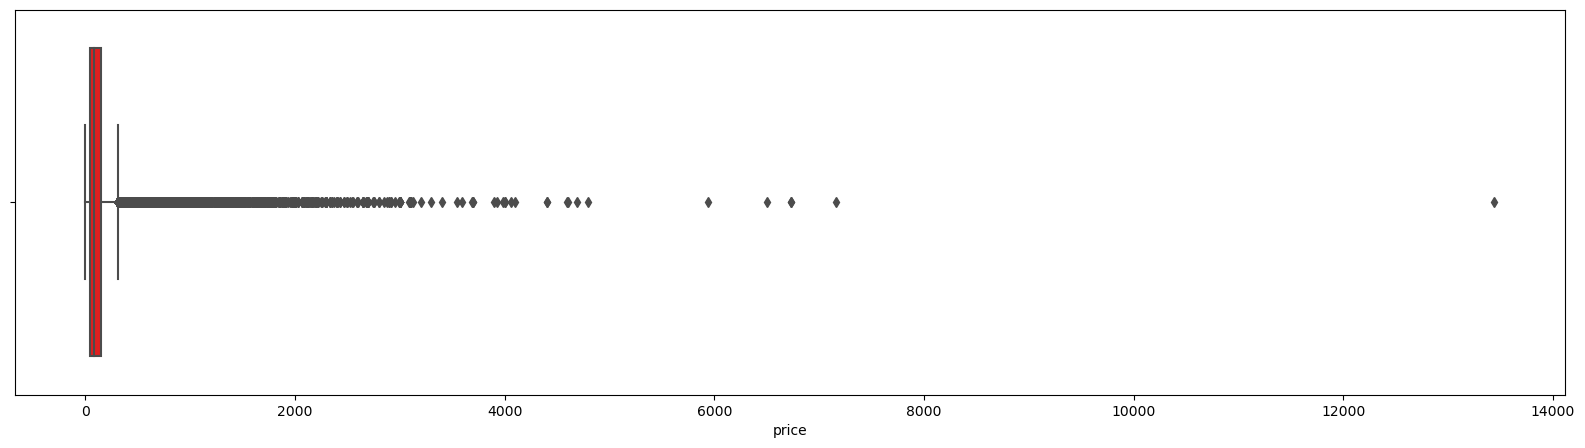

In [17]:
#Data Order Prices Analysis
plt.figure(figsize=(20,5))
sns.boxplot(x=priceGrouped, color='red')

<AxesSubplot:title={'center':'Total Price (Order Value in R$) by State of the Customer'}, xlabel='customer_state', ylabel='price'>

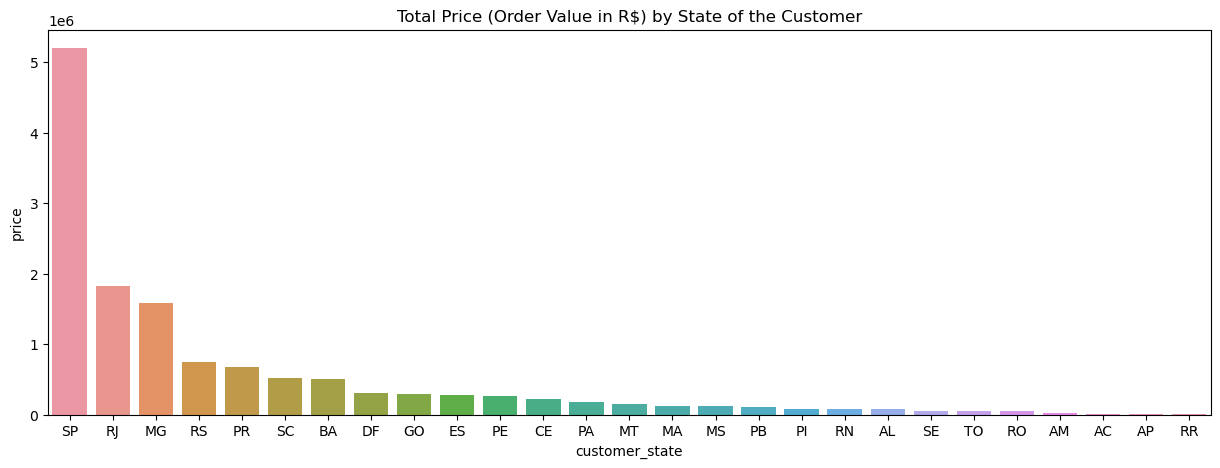

In [16]:
totalByState = data.groupby('customer_state')['price'].sum().sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.title('Total Price (Order Value in R$) by State of the Customer')
sns.barplot(x=totalByState.index, y=totalByState)

<AxesSubplot:title={'center':'Total Orders (Count) by State of the Customer'}, xlabel='customer_state', ylabel='order_id'>

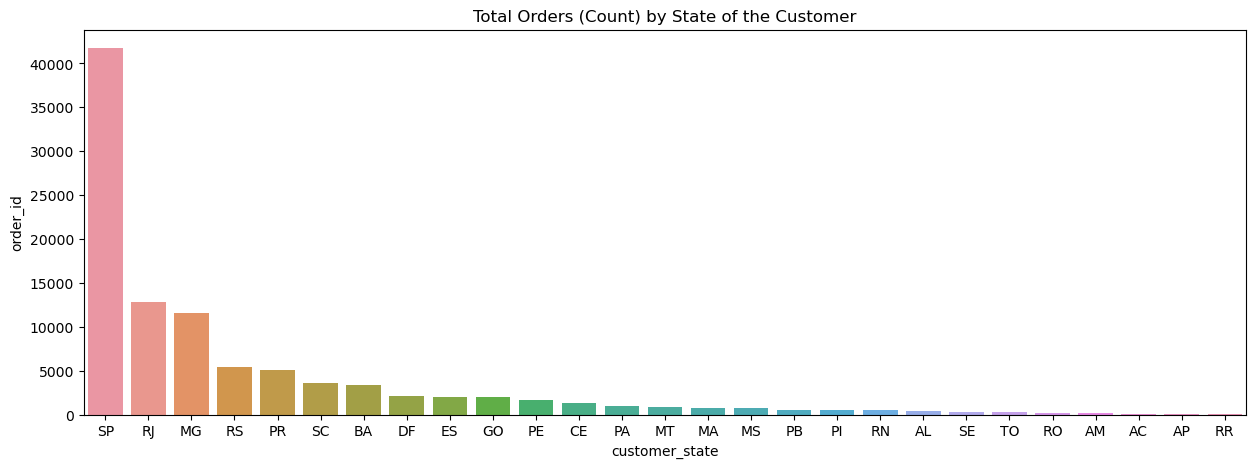

In [18]:
totalOrdersByState = data.groupby('customer_state')['order_id'].nunique().sort_values(ascending=False)
totalOrdersByState

plt.figure(figsize=(15,5))
plt.title('Total Orders (Count) by State of the Customer')
sns.barplot(x=totalOrdersByState.index, y=totalOrdersByState)

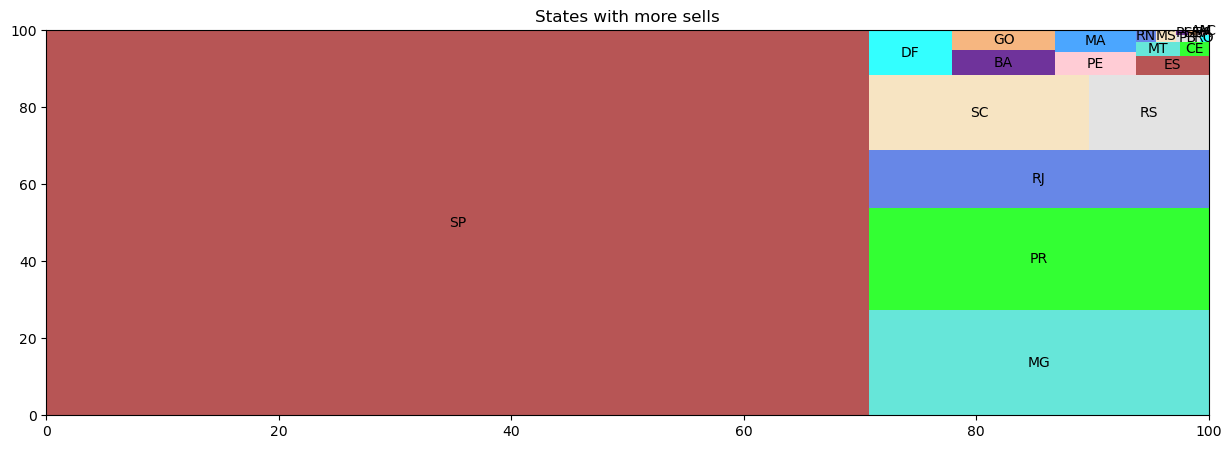

In [19]:
totalSellerByState = data.groupby('seller_state')['order_id'].nunique().sort_values(ascending=False)
totalSellerByState

# Define the plot sizes
fig, ax = plt.subplots(1, figsize = (15,5))
plt.title('States with more sells')

sq.plot(sizes= totalSellerByState,
        color = ['brown','turquoise','lime','royalblue','wheat','gainsboro','aqua','indigo','sandybrown','pink','dodgerblue'],
        label= totalSellerByState.index,
        alpha = .8)

plt.show()

<AxesSubplot:title={'center':'Average freight value in R$ by State of the Customer'}, xlabel='customer_state'>

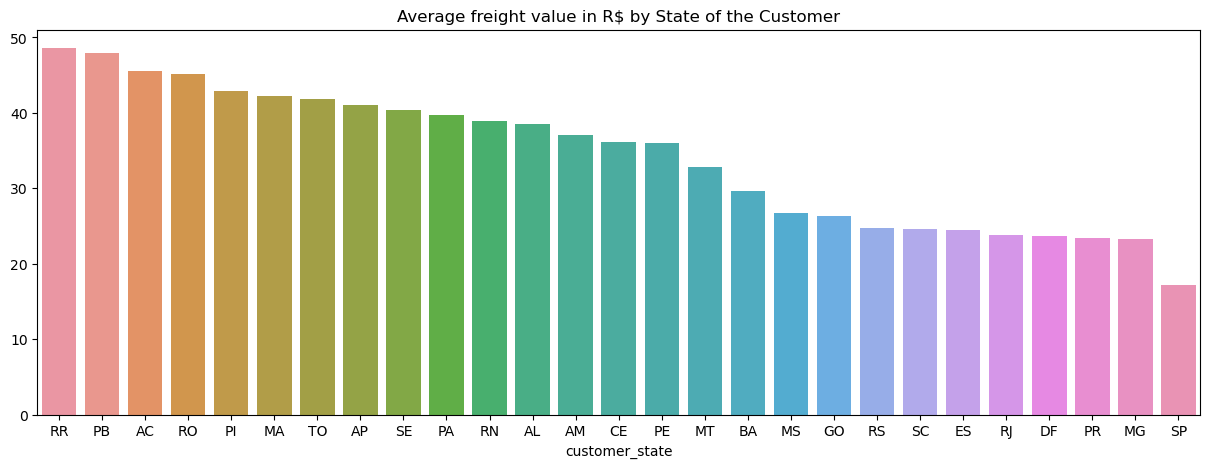

In [20]:
freightAvgState = (data.groupby('customer_state')['freight_value'].sum() /data.groupby('customer_state')['order_id'].nunique()).sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.title('Average freight value in R$ by State of the Customer')
sns.barplot(x=freightAvgState.index, y=freightAvgState)

In [23]:
data_list_geolocation = data_list_geolocation.drop_duplicates(subset='geolocation_zip_code_prefix', keep='first')

dataNonDuplicates = data.drop_duplicates(subset='customer_unique_id', keep='first')

dataGeo = pd.merge(dataNonDuplicates[['order_status','seller_city','seller_state','customer_city','customer_state', 'customer_zip_code_prefix']], 
                                     data_list_geolocation, 
                                     left_on='customer_zip_code_prefix', 
                                     right_on='geolocation_zip_code_prefix')

In [24]:
mapCustomers = folium.Map(location=[-15.7941, -47.8825], 
                          tiles='cartodbpositron', 
#                           width=700, height=400,
                          zoom_start=5)

HeatMap(data=dataGeo[['geolocation_lat', 'geolocation_lng']], 
                     radius=13).add_to(mapCustomers)

print('Where are the active clients from: ')
mapCustomers

Where are the active clients from: 


<AxesSubplot:title={'center':'Top 10 categories of products with more orders'}, xlabel='product_category_name'>

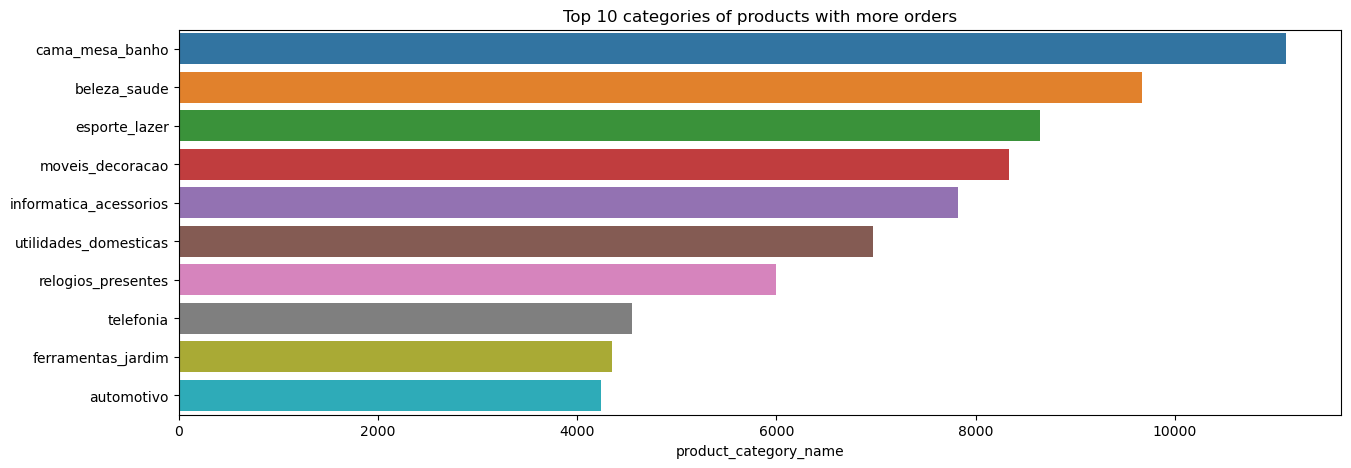

In [25]:
productCategoryOrders = data['product_category_name'].value_counts().head(10)

plt.figure(figsize=(15,5))
plt.title('Top 10 categories of products with more orders')
sns.barplot(y=productCategoryOrders.index, x=productCategoryOrders, orient='h')

In [26]:
dataReviews = pd.merge(dataNonDuplicates[['order_id','seller_city','seller_state','customer_city','customer_state', 'order_status', 
                                          'order_purchase_timestamp', 'order_estimated_delivery_date', 'price', 'freight_value', 'product_photos_qty']], 
                                          data_list_order_reviews, 
                                          on='order_id', how='left')

<AxesSubplot:title={'center':'Reviews'}, xlabel='review_score'>

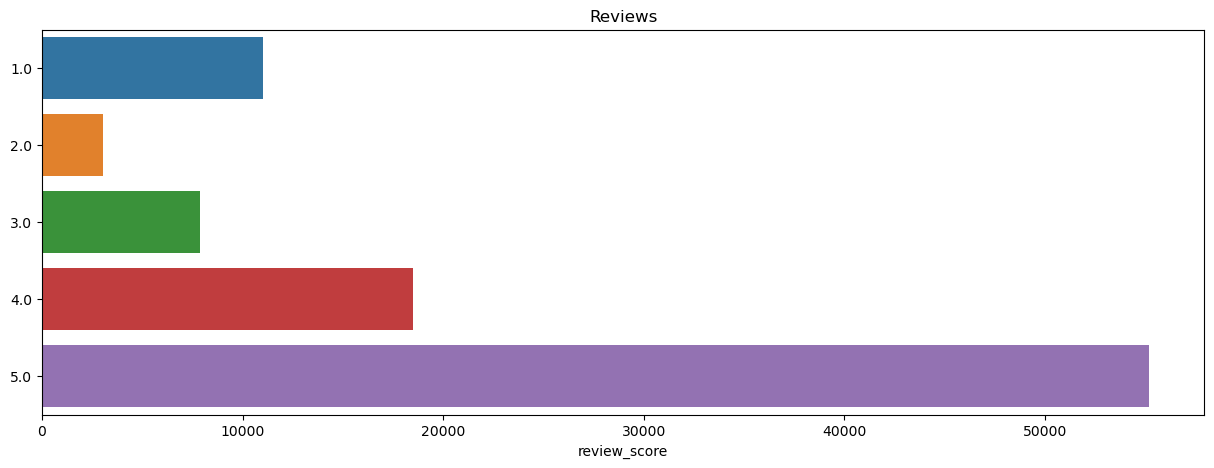

In [27]:
reviewsScore = dataReviews.review_score.value_counts()

plt.figure(figsize=(15,5))
plt.title('Reviews')
sns.barplot(y=reviewsScore.index, x=reviewsScore, orient='h')

In [28]:
sellerStateReviews = dataReviews.groupby('seller_state')['review_score'].mean()
customerStateReviews = dataReviews.groupby('customer_state')['review_score'].mean()

concatReviews = pd.concat([sellerStateReviews.rename('seller'), customerStateReviews.rename('customer')], axis=1)

<AxesSubplot:ylabel='customer'>

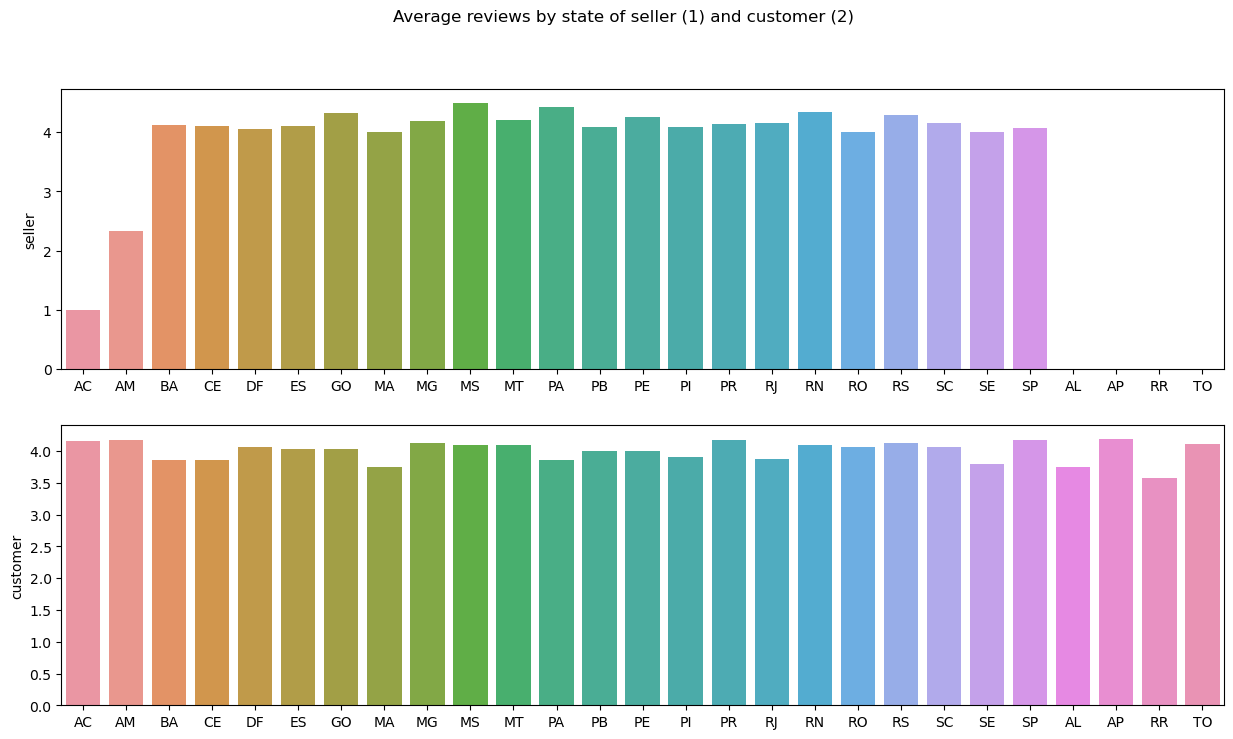

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
fig.suptitle('Average reviews by state of seller (1) and customer (2)')

sns.barplot(x=concatReviews.index, y=concatReviews.seller, ax=axes[0])

sns.barplot(x=concatReviews.index, y=concatReviews.customer, ax=axes[1])

In [30]:
# Convert objects date columns to dates desconsidering the errors
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for column in dateColumns:
    data[column] = pd.to_datetime(data[column], errors='coerce')

#Calculate the difference between the estimated date and the delivery (negative values means delay)
data['DiffDeliveryDays'] = ((data['order_estimated_delivery_date'] - data['order_delivered_customer_date']).dt.days) + 1

#Calculate the time between end of purchase and delivery
data['DeliveryCountDays'] = ((data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days)

In [31]:
data[['order_estimated_delivery_date', 'order_delivered_customer_date', 'DiffDeliveryDays', 'order_purchase_timestamp','DeliveryCountDays']]

order_estimated_delivery_date order_delivered_customer_date  \
0                         2017-10-18           2017-10-10 21:25:13   
1                         2017-08-28           2017-08-18 14:44:43   
2                         2017-08-15           2017-08-07 18:30:01   
3                         2017-11-13           2017-11-07 18:04:59   
4                         2017-08-23           2017-08-16 19:03:36   
...                              ...                           ...   
113420                    2018-07-20           2018-07-09 15:06:57   
113421                    2017-03-30                           NaT   
113422                    2018-08-16           2018-08-02 22:47:35   
113423                    2018-06-08           2018-06-12 23:11:29   
113424                    2018-05-29           2018-05-21 14:31:41   

        DiffDeliveryDays order_purchase_timestamp  DeliveryCountDays  
0                    8.0      2017-10-02 10:56:33                8.0  
1                   10.0      2017-08-15 18:29:31                2.0  
2                    8.0      2017-08-02 18:24:47                5.0  
3                    6.0      2017-10-23 23:26:46               14.0  
4                    7.0      2017-08-10 13:35:55                6.0  
...                  ...                      ...                ...  
113420              11.0      2018-07-01 10:23:10                8.0  
113421               NaN      2017-03-11 19:51:36                NaN  
113422              14.0      2018-07-24 09:46:27                9.0  
113423              -4.0      2018-05-22 21:13:21               21.0  
113424               8.0      2018-05-15 17:41:00                5.0  

[113425 rows x 5 columns]

In [32]:
reviewsByDates = pd.merge(data[['order_id', 'seller_id','DeliveryCountDays', 'DiffDeliveryDays', 'order_purchase_timestamp']], 
                                 data_list_order_reviews, 
                                 on='order_id', how='left')

reviewsByDates.corr()['review_score'].drop('review_score')

DeliveryCountDays   -0.304058
DiffDeliveryDays     0.229030
Name: review_score, dtype: float64

<AxesSubplot:xlabel='DiffDeliveryDays', ylabel='review_score'>

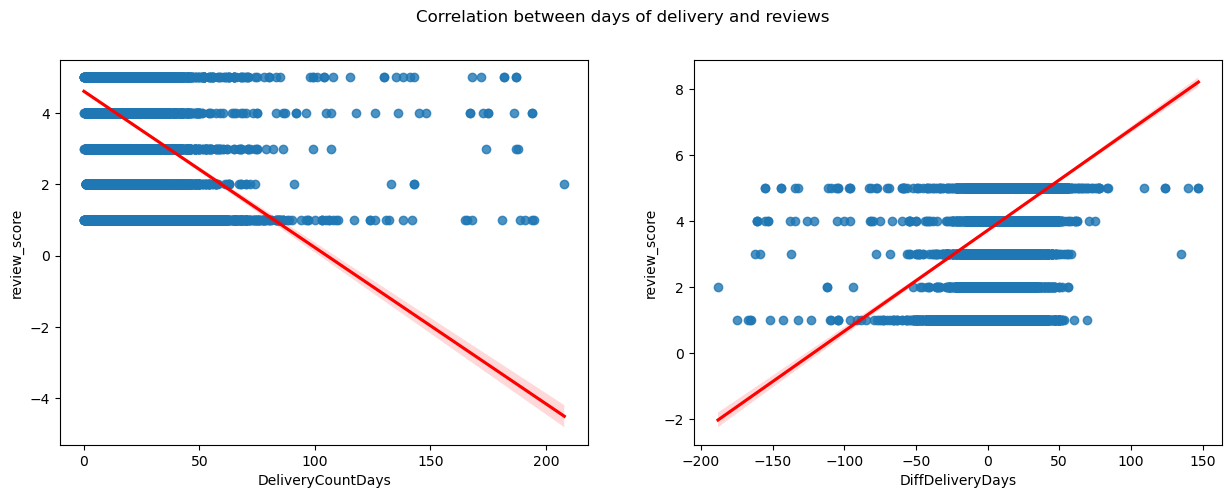

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Correlation between days of delivery and reviews')

sns.regplot(x='DeliveryCountDays', y='review_score', data=reviewsByDates, ax=axes[0], line_kws={"color": "red"})

sns.regplot(x='DiffDeliveryDays', y='review_score', data=reviewsByDates, ax=axes[1], line_kws={"color": "red"})

In [34]:
print('Average review score for dalayed items:',(reviewsByDates[reviewsByDates.DiffDeliveryDays<0]['review_score'].mean()))
print('Average review score for anticipated items:',(reviewsByDates[reviewsByDates.DiffDeliveryDays>0]['review_score'].mean()))

Average review score for dalayed items: 2.256572472936876
Average review score for anticipated items: 4.210475993336685


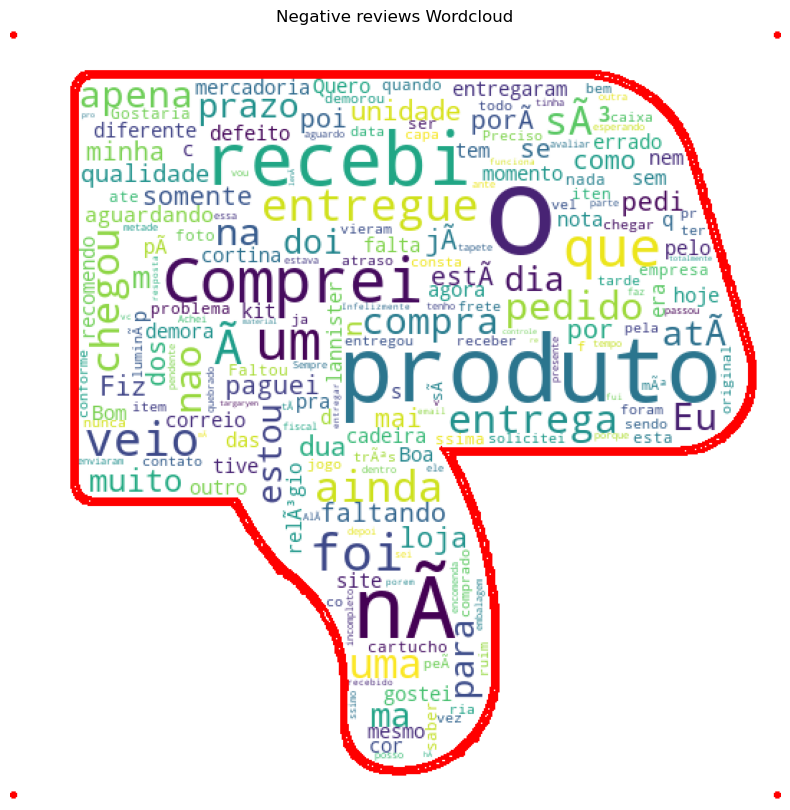

In [35]:
negReviewsText = reviewsByDates[reviewsByDates.review_score <3]['review_comment_message'].dropna()

# Words to desconsider on the visualization
stopwords = set(STOPWORDS)
stopwords.update(["/n" ,"da", "meu", "em", "você", "de", "ao", "os", "e", 'ou', 'é'])
 

def open_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_np = np.array(img)
    return img_np

mask = open_img('https://cdn-images-1.medium.com/max/537/1*CK7ulJRe6nqeorManOJUzg.png')


# WordCLoud generate
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Reds', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Red',
                      collocations=False, 
                      repeat = False,                   
                      width=700, height=700).generate(negReviewsText.to_string(index=False))
 
# Configure visualization of the image
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
#Show Img 
plt.title('Negative reviews Wordcloud')
plt.imshow(wordcloudInst)

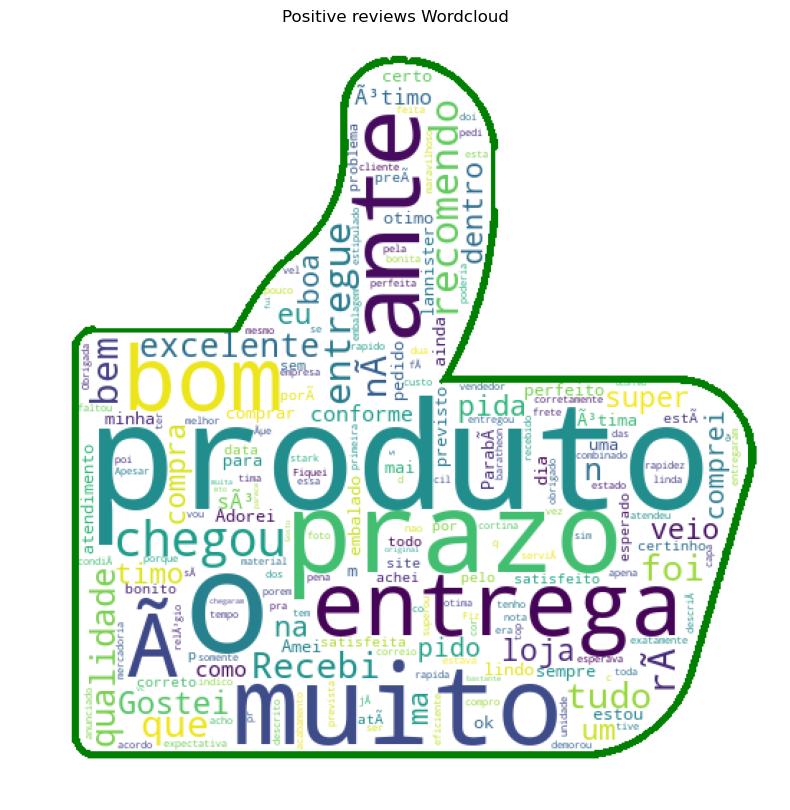

In [36]:
posReviewsText = reviewsByDates[reviewsByDates.review_score >=3]['review_comment_message'].dropna()

mask = open_img("https://cdn-images-1.medium.com/max/537/1*q4vrNnlsX_d4glglS35AGw.png")


# WordCLoud generate
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Greens', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Green',  
                      collocations=False, 
                      repeat = False,    
                      width=700, height=700).generate(posReviewsText.to_string(index=False))
 
# Configure visualization of the image
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
#Show Img 
plt.title('Positive reviews Wordcloud')
plt.imshow(wordcloudInst)

In [37]:
worstSellers = pd.DataFrame(reviewsByDates[reviewsByDates['DiffDeliveryDays'] < 0].groupby('seller_id')['DiffDeliveryDays'].count().sort_values(ascending=False).head(50)).reset_index()
worstSellers.head(5)

#If we want to see the sellers on details:
# data_sellers.merge(worstSellers, on='seller_id', how='right')

seller_id  DiffDeliveryDays
0  4a3ca9315b744ce9f8e9374361493884               191
1  1f50f920176fa81dab994f9023523100               151
2  4869f7a5dfa277a7dca6462dcf3b52b2               121
3  7c67e1448b00f6e969d365cea6b010ab               121
4  6560211a19b47992c3666cc44a7e94c0               103

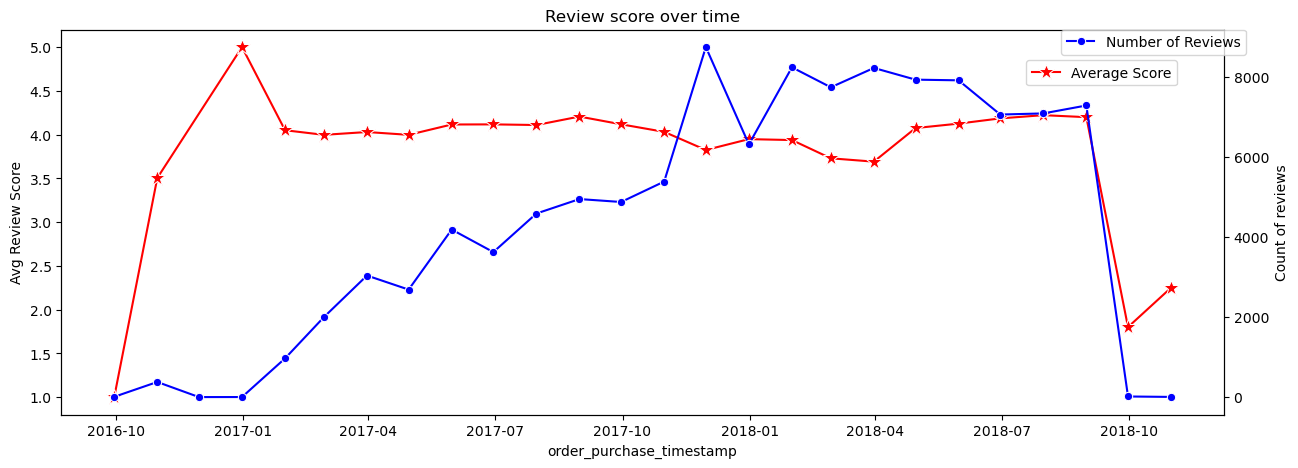

In [38]:
#Create a month-grouped review score
dateScores = reviewsByDates.set_index('order_purchase_timestamp', inplace=False)

#Calculate the mean review score over time
dateScoresCount = pd.DataFrame(dateScores.resample('m')['review_score'].count())
dateScoresMean = pd.DataFrame(dateScores.resample('m')['review_score'].mean())

fig, ax_left = plt.subplots(figsize=(15,5))
ax_right = ax_left.twinx()

ax_right.set_ylabel('Count of reviews')
ax_left.set_ylabel('Avg Review Score')


plt.title('Review score over time')
ax_right = sns.lineplot(x='order_purchase_timestamp', y='review_score', ax = ax_right, data=dateScoresCount, color='blue', marker='o', label='Number of Reviews')
ax_left = sns.lineplot(x='order_purchase_timestamp', y='review_score', ax = ax_left, data=dateScoresMean, color='red', marker='*', markersize=12, label='Average Score')

ax_right.legend(bbox_to_anchor=(.86, 1), loc='upper left', borderaxespad=0.)
ax_left.legend(bbox_to_anchor=(.83, 0.92), loc='upper left', borderaxespad=0.)

plt.show()

<AxesSubplot:title={'center':'Average review score by payment type'}, xlabel='payment_type', ylabel='review_score'>

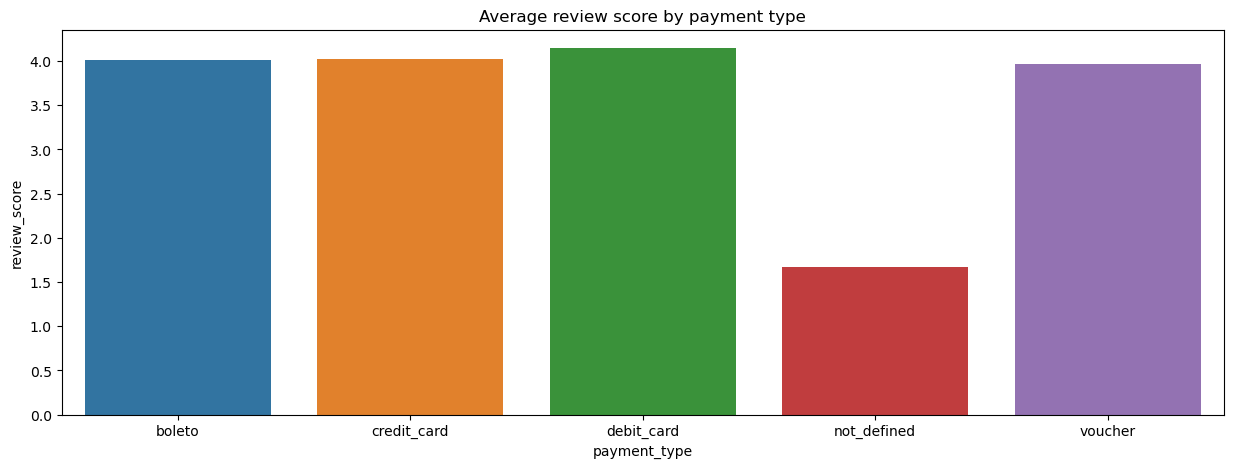

In [40]:
#Voucher vs reviews

#join usind order id as key
reviewsByPayments = pd.merge(reviewsByDates[['order_id', 'review_score']], data_list_order_payments[['order_id', 'payment_type']], on='order_id', how='left')
reviewsByPayments = reviewsByPayments.groupby('payment_type')['review_score'].mean()

plt.figure(figsize=(15,5))
plt.title('Average review score by payment type')
sns.barplot(x=reviewsByPayments.index, y=reviewsByPayments)

<AxesSubplot:title={'center':'Average difference days from positive review score orders \n with and without review comments'}>

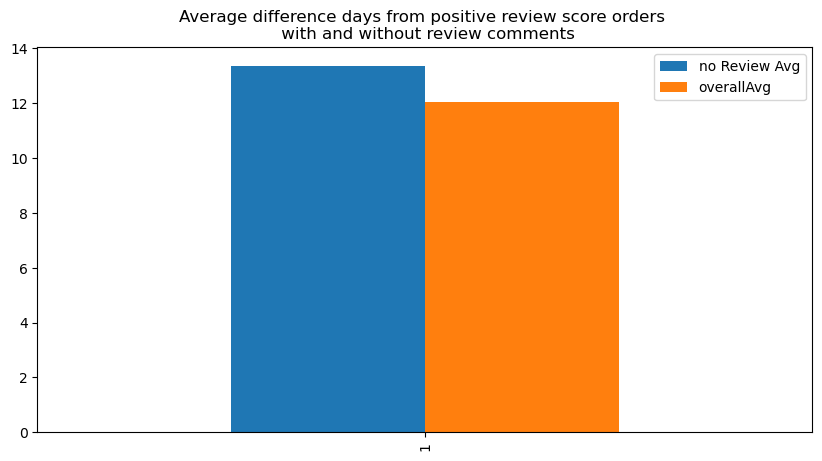

In [41]:
#Find the Order id of orders with good review score and no description of the review.
idReviewsNonDescriptive = reviewsByDates[(reviewsByDates['review_score']>=5) & (reviewsByDates['review_comment_message'].isna())]
idReviewsNonDescriptive = idReviewsNonDescriptive.merge(data[['order_id', 'DiffDeliveryDays', 'DeliveryCountDays', 'price', 'product_category_name']])

idReviewsNonMeans = pd.DataFrame({'no Review Avg': idReviewsNonDescriptive.DiffDeliveryDays.mean(), 
                                  'overallAvg': data.DiffDeliveryDays.mean()}, index=[1])

idReviewsNonMeans.plot(kind='bar', figsize=(10,5), title='Average difference days from positive review score orders \n with and without review comments')

<AxesSubplot:title={'center':'Average DeliveryCountDays days from positive review score orders\n with and without review comments'}>

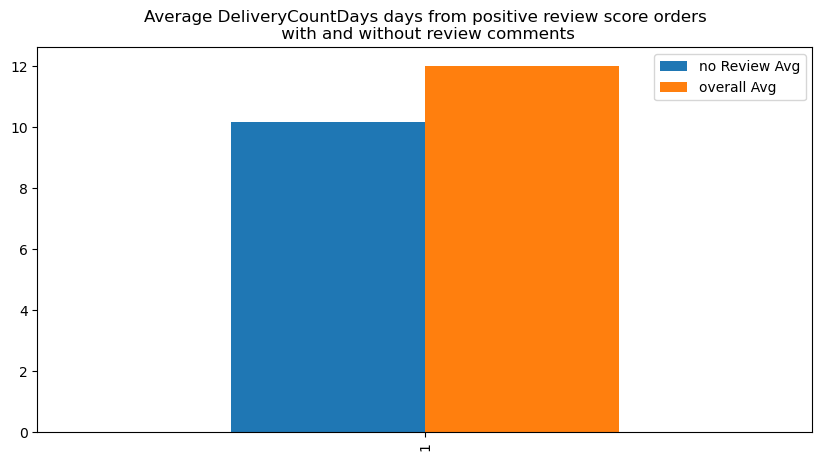

In [42]:
#Find the Order id of orders with good review score and no description of the review.
idReviewsNonMeans = pd.DataFrame({'no Review Avg': idReviewsNonDescriptive.DeliveryCountDays.mean(), 
                                  'overall Avg': data.DeliveryCountDays.mean()}, index=[1])

idReviewsNonMeans.plot(kind='bar', figsize=(10,5), title='Average DeliveryCountDays days from positive review score orders\n with and without review comments')

In [43]:
prodCatReviews = pd.merge(data[['product_id','order_id','DiffDeliveryDays']], data_list_products[['product_category_name','product_id']], on='product_id', how='left')

prodCatReviews = prodCatReviews.merge(dataReviews[['order_id', 'price','review_score', 'review_comment_message']], on='order_id', how='left')

<AxesSubplot:title={'center':'Correlation between price and reviews'}, xlabel='review_score', ylabel='price'>

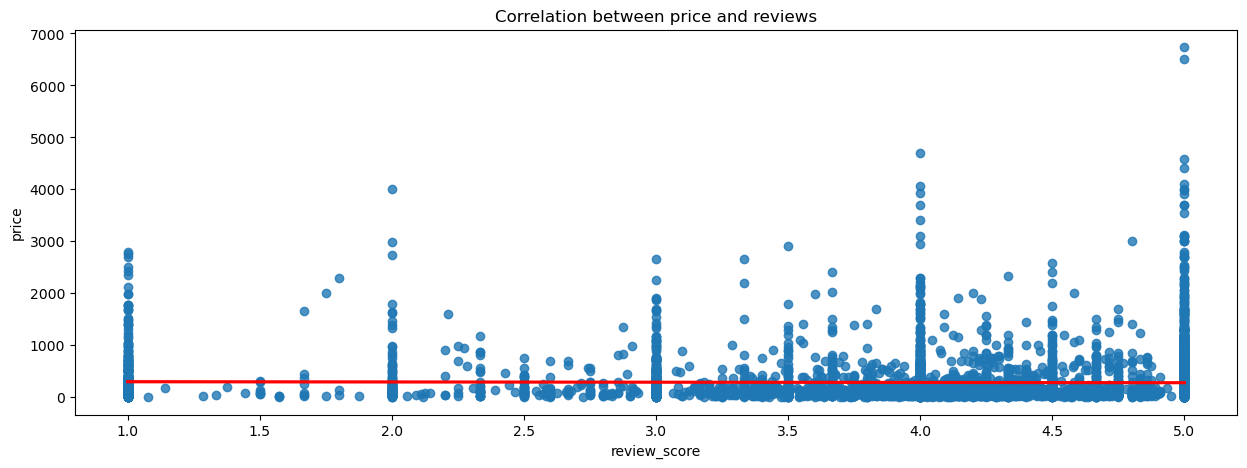

In [44]:
prodCatReviewsByPrice = pd.DataFrame(prodCatReviews.groupby('price')['review_score'].mean()).reset_index()

plt.figure(figsize=(15,5))
plt.title('Correlation between price and reviews')
sns.regplot(y='price', x='review_score', data=prodCatReviewsByPrice, line_kws={"color": "red"})

In [45]:
c1 = prodCatReviewsByPrice[prodCatReviewsByPrice['price']<30]['review_score'].mean()
c2 = prodCatReviewsByPrice[(prodCatReviewsByPrice['price']>=30) & (prodCatReviewsByPrice['price']<100)]['review_score'].mean()
c3 = prodCatReviewsByPrice[(prodCatReviewsByPrice['price']>=100) & (prodCatReviewsByPrice['price']<1000)]['review_score'].mean()
c4 = prodCatReviewsByPrice[(prodCatReviewsByPrice['price']>=1000)]['review_score'].mean()

levels = ['up to R$30', 'R$30 - R$100', 'R$100 - R$1000', 'above R$1000']

for i in range(len(levels)):
    value = 'c{}'.format(i+1)
    print('Avg Review Score for price {}: {}'.format(levels[i], globals()[value]))


Avg Review Score for price up to R$30: 4.094446670558732
Avg Review Score for price R$30 - R$100: 4.076310833526949
Avg Review Score for price R$100 - R$1000: 4.043354180860942
Avg Review Score for price above R$1000: 4.032640587088438


<AxesSubplot:xlabel='review_score', ylabel='product_category_name'>

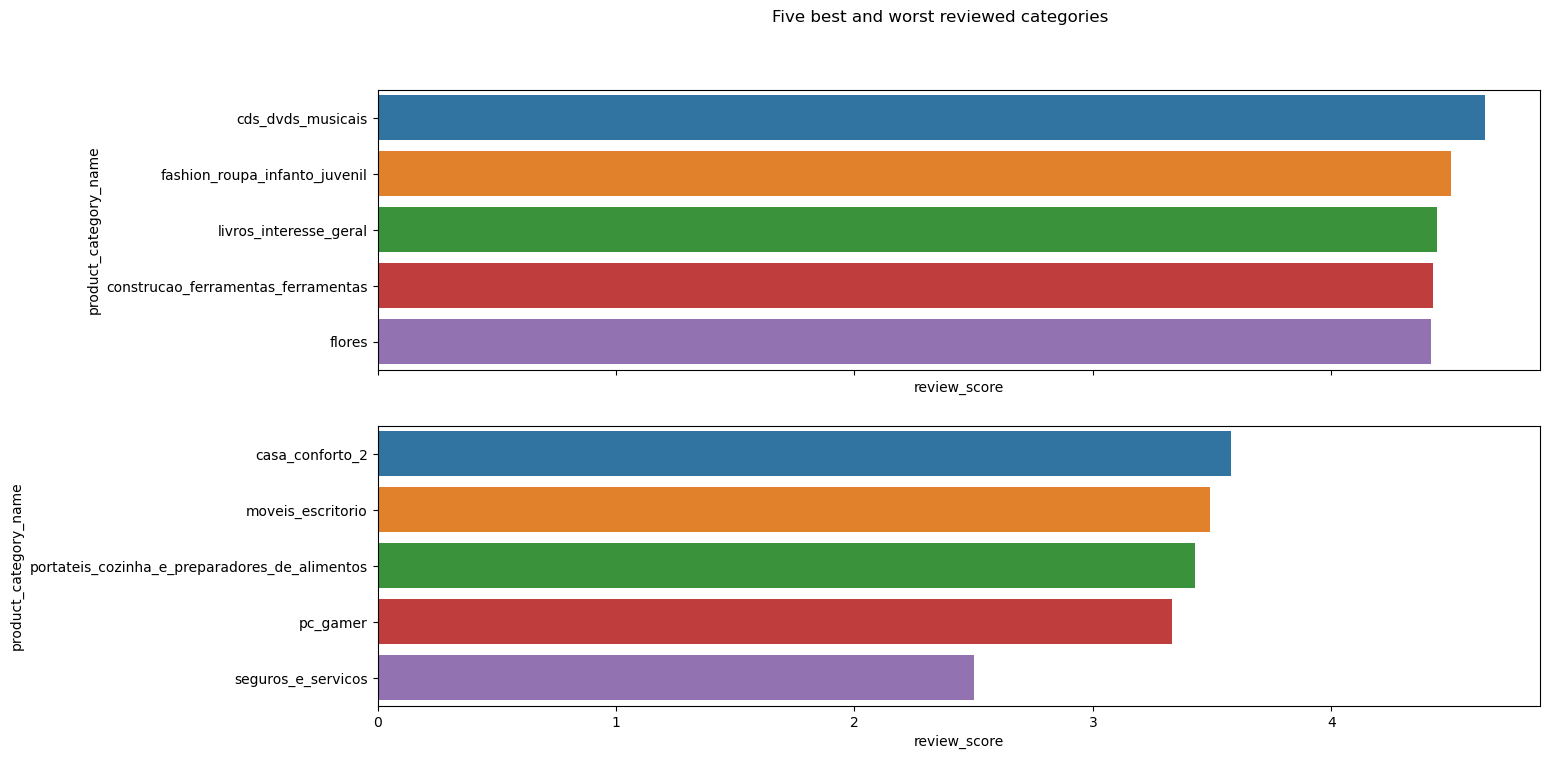

In [46]:
plotCats = pd.DataFrame(prodCatReviews.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15,8), sharex=True)
fig.suptitle('Five best and worst reviewed categories')

sns.barplot(y='product_category_name', x='review_score', ax=axes[0], data=plotCats.head(5))
sns.barplot(y='product_category_name', x='review_score', ax=axes[1], data=plotCats.tail(5))


<AxesSubplot:title={'center':'Outliers from best and worst reviewed categories'}, xlabel='review_score'>

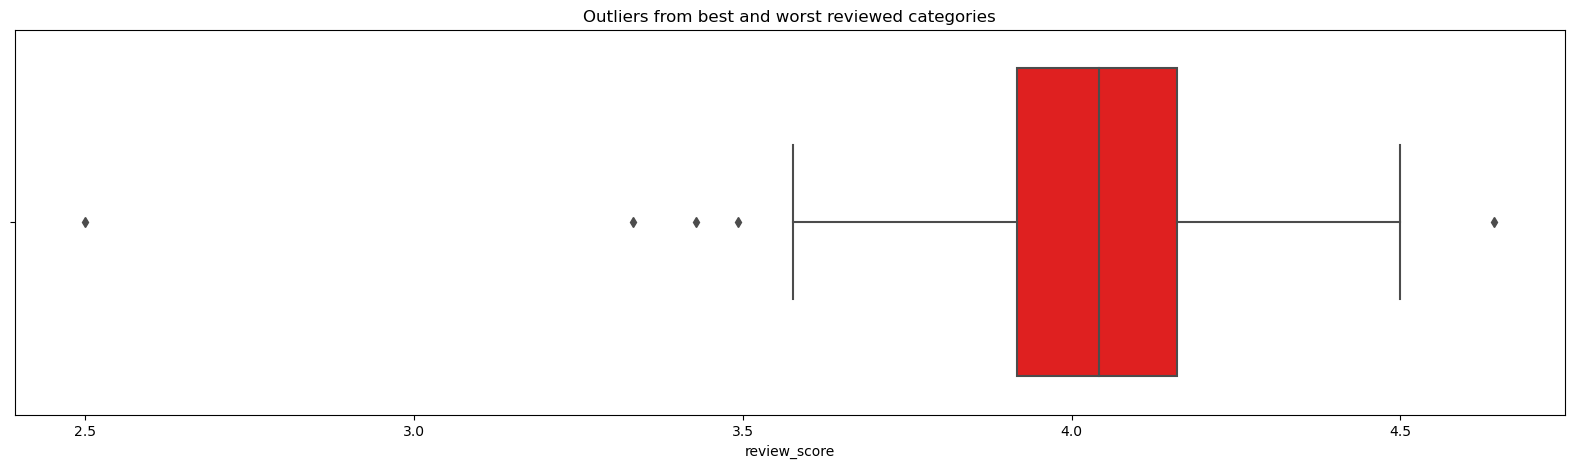

In [47]:
#Data Order Prices Analysis
plt.figure(figsize=(20,5))
plt.title('Outliers from best and worst reviewed categories')
sns.boxplot(x=plotCats.review_score, color='red')

<AxesSubplot:xlabel='review_score', ylabel='product_category_name'>

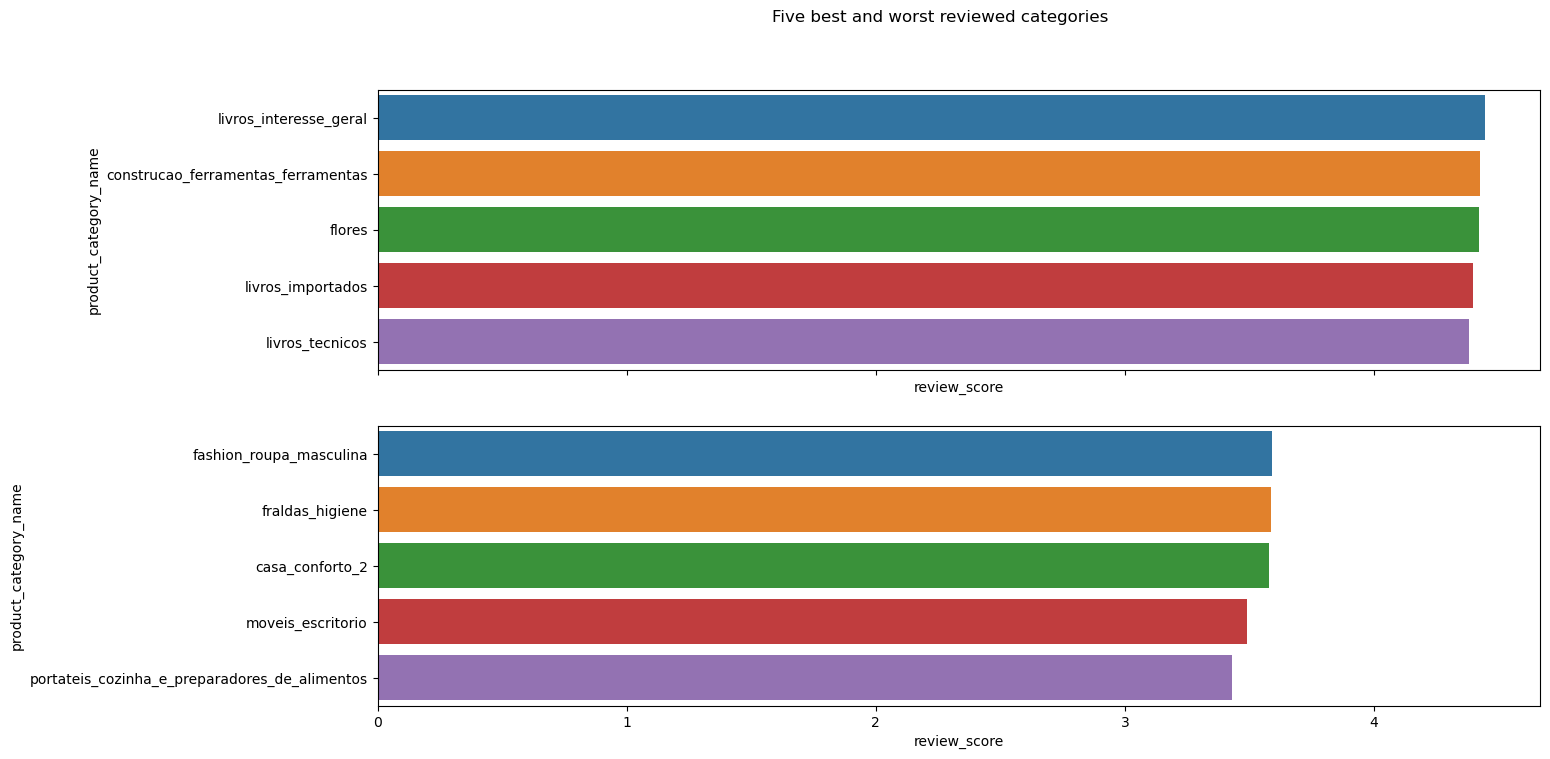

In [48]:
#select the categories with less orders/reviews
irrelevant_Cat = prodCatReviews.groupby('product_category_name')['order_id'].count().sort_values().head(5).index

#desconsider this list of categories on our set for the plot
plotCats = plotCats[~plotCats['product_category_name'].isin(irrelevant_Cat)]

#plot
fig, axes = plt.subplots(2, 1, figsize=(15,8), sharex=True)
fig.suptitle('Five best and worst reviewed categories')

sns.barplot(y='product_category_name', x='review_score', ax=axes[0], data=plotCats.head(5))
sns.barplot(y='product_category_name', x='review_score', ax=axes[1], data=plotCats.tail(5))

In [50]:
#select the cities with more delay averages
moreDelays = data.groupby('customer_city')['DiffDeliveryDays'].mean().sort_values().dropna().head(100).index

#desconsider this list of categories on our set for the plot
delayGeo = data[data['customer_city'].isin(moreDelays)]


delayGeo = pd.merge(delayGeo[['customer_zip_code_prefix']], 
                              data_list_geolocation, 
                              left_on='customer_zip_code_prefix', 
                              right_on='geolocation_zip_code_prefix')


mapDeliveryDelay = folium.Map(location=[-15.7941, -47.8825], 
                              tiles='cartodbpositron', 
                          #   width=700, height=400,
                              zoom_start=5)

HeatMap(data=delayGeo[['geolocation_lat', 'geolocation_lng']], 
                        radius=20).add_to(mapDeliveryDelay)

print('Where are the worst delays average: ')
mapDeliveryDelay

Where are the worst delays average: 


## Data Science

In [51]:
#Day of the week feature creation
data['weekDay'] = data.order_approved_at.dt.weekday

lastOrder = data.order_purchase_timestamp.max()

#Recency feature creation
print('Last order on the dataset is at:', lastOrder)

data['recency'] = ((lastOrder - data['order_purchase_timestamp']).dt.days)

#Frequency of purchases feature creation - How many unique orders does each customer have
data['totalOrders'] = data.groupby('customer_unique_id')['order_id'].transform('nunique')

#Total Spent feature creation
data['totalSpent'] = data.groupby('customer_unique_id')['price'].transform('sum')


Last order on the dataset is at: 2018-10-17 17:30:18


In [52]:
clusteringData = data[['customer_unique_id', 'totalOrders', 'totalSpent', 'recency']]

#group by the id and show the total orders and total spent, using the minimum recency when there are more than 2 orders.
clusteringData = clusteringData.loc[clusteringData.groupby('customer_unique_id').recency.idxmin()] #.set_index('customer_unique_id')

clusteringData

customer_unique_id  totalOrders  totalSpent  recency
33312  0000366f3b9a7992bf8c76cfdf3221e2            1      129.90      160
89315  0000b849f77a49e4a4ce2b2a4ca5be3f            1       18.90      163
36238  0000f46a3911fa3c0805444483337064            1       69.00      585
38771  0000f6ccb0745a6a4b88665a16c9f078            1       25.99      369
8326   0004aac84e0df4da2b147fca70cf8255            1      180.00      336
...                                 ...          ...         ...      ...
64353  fffcf5a5ff07b0908bd4e2dbc735a684            1     1570.00      495
60904  fffea47cd6d3cc0a88bd621562a9d061            1       64.89      310
99246  ffff371b4d645b6ecea244b27531430a            1       89.90      617
11834  ffff5962728ec6157033ef9805bacc48            1      115.00      168
9817   ffffd2657e2aad2907e67c3e9daecbeb            1       56.99      532

[96096 rows x 4 columns]

#### Outliers removing

<AxesSubplot:title={'center':'Outliers from total Spent feature'}, xlabel='totalSpent'>

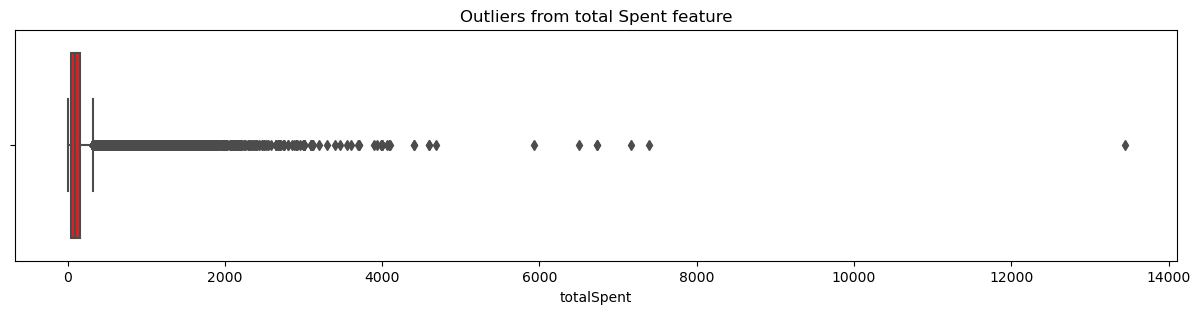

In [53]:
#Total Spent Outliers
plt.figure(figsize=(15,3))
plt.title('Outliers from total Spent feature')
sns.boxplot(x=clusteringData.totalSpent, color='red')

Old Shape:  (96096, 4)
Lower bound: -116.02499999999998
Upper bound: 316.015
New Shape:  (96096, 4)


<AxesSubplot:title={'center':'Total Spent features without outliers'}, xlabel='totalSpent'>

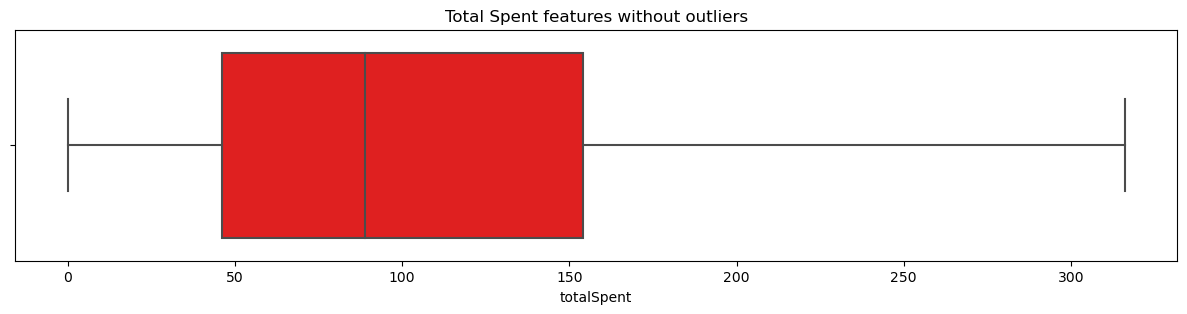

In [54]:
#Detect the outliers using IQR technique

q1 = clusteringData['totalSpent'].quantile(0.25)
q3 = clusteringData['totalSpent'].quantile(0.75)
iqr = q3 - q1
 
print("Old Shape: ", clusteringData.shape)
 
#Upper and Lower Limits
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

print("Lower bound:", lower)
print("Upper bound:", upper)
 
# new_df = data[data['Income'] > upper]
# new_df = data[data['Income']  < lower]

# Capping (above or below certain limit, all Incomes will be the same)

clusteringData['totalSpent'] = np.where(clusteringData['totalSpent'] > upper, upper, 
                               np.where(clusteringData['totalSpent'] < lower, lower,
                               clusteringData['totalSpent']))

print("New Shape: ", clusteringData.shape)

#distribution of Income without the greater outliers
plt.figure(figsize=(15,3))
plt.title('Total Spent features without outliers')
sns.boxplot(x=clusteringData['totalSpent'], color='red')

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

dataTime = data[['order_id', 'order_purchase_timestamp', 'price']].set_index('order_purchase_timestamp', inplace=False)

dataTimeMean = pd.DataFrame(dataTime.resample('W')['price'].sum()) #resample using weeks as parameter
# dataTimeMean = dataTimeMean.fillna(0)
dataTimeMean.drop(dataTimeMean.tail(8).index, inplace=True) # Drop the last observations with 0 

#Decompose Time Series
decompose = seasonal_decompose(dataTimeMean, extrapolate_trend=12)

#Trend
obs = decompose.observed
#Trend
trend = decompose.trend
#Seazonal
seazon = decompose.seasonal
#Error
random = decompose.resid

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='resid'>

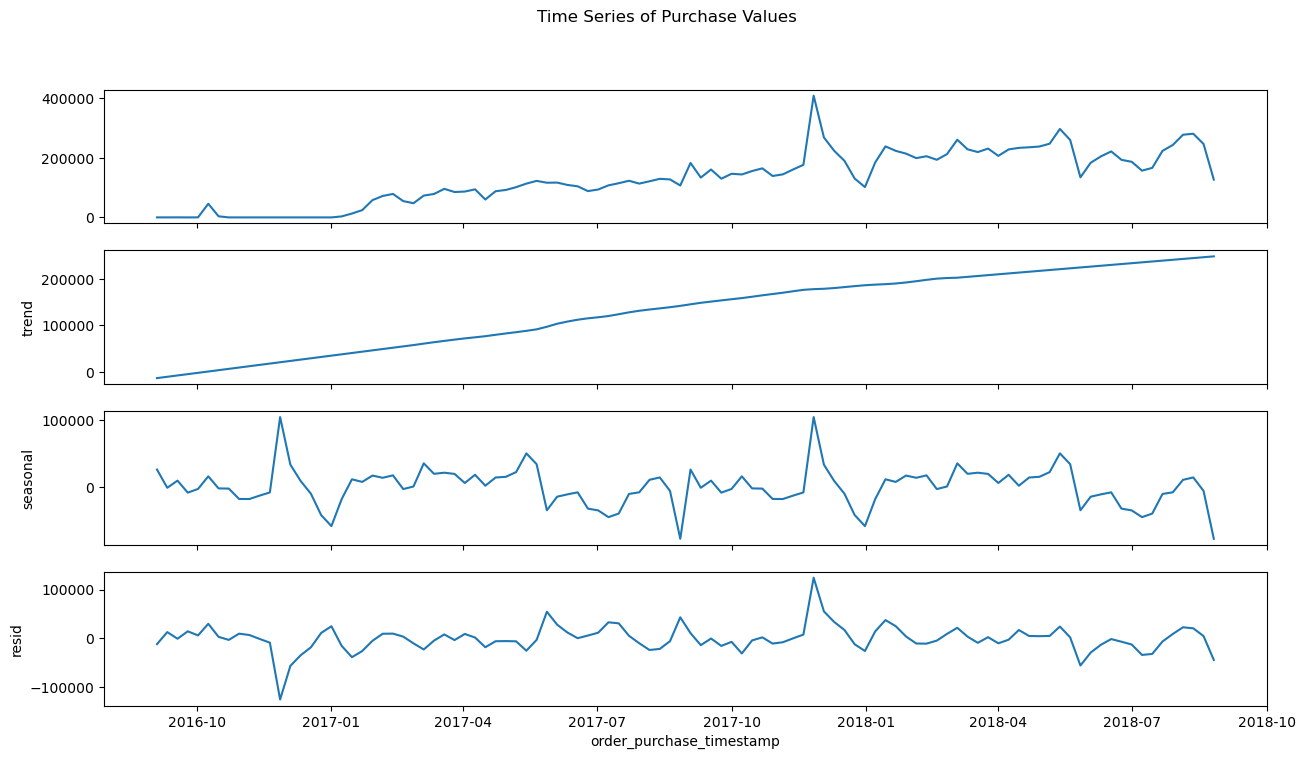

In [63]:
#plot
fig, axes = plt.subplots(4, 1, figsize=(15,8), sharex=True)
fig.suptitle('Time Series of Purchase Values')

sns.lineplot(x=obs.index, y=obs, ax=axes[0], data=obs)
sns.lineplot(x=trend.index, y=trend, ax=axes[1], data=trend)
sns.lineplot(x=seazon.index, y=seazon, ax=axes[2], data=seazon)
sns.lineplot(x=random.index, y=random, ax=axes[3], data=random)

In [64]:
#Is the data stationary?
adfTest = ADFTest(alpha=0.05)
adfTest.should_diff(dataTimeMean)

(0.11460069440775776, True)

In [65]:
dataTimeMean['x1'] = dataTimeMean.price.shift(1)

dataTimeMean.dropna(axis=0, inplace=True)

dataTimeMean.head()

price      x1
order_purchase_timestamp                  
2016-09-11                   59.50   72.89
2016-09-18                  134.97   59.50
2016-09-25                    0.00  134.97
2016-10-02                  100.00    0.00
2016-10-09                45715.09  100.00

<AxesSubplot:xlabel='order_purchase_timestamp'>

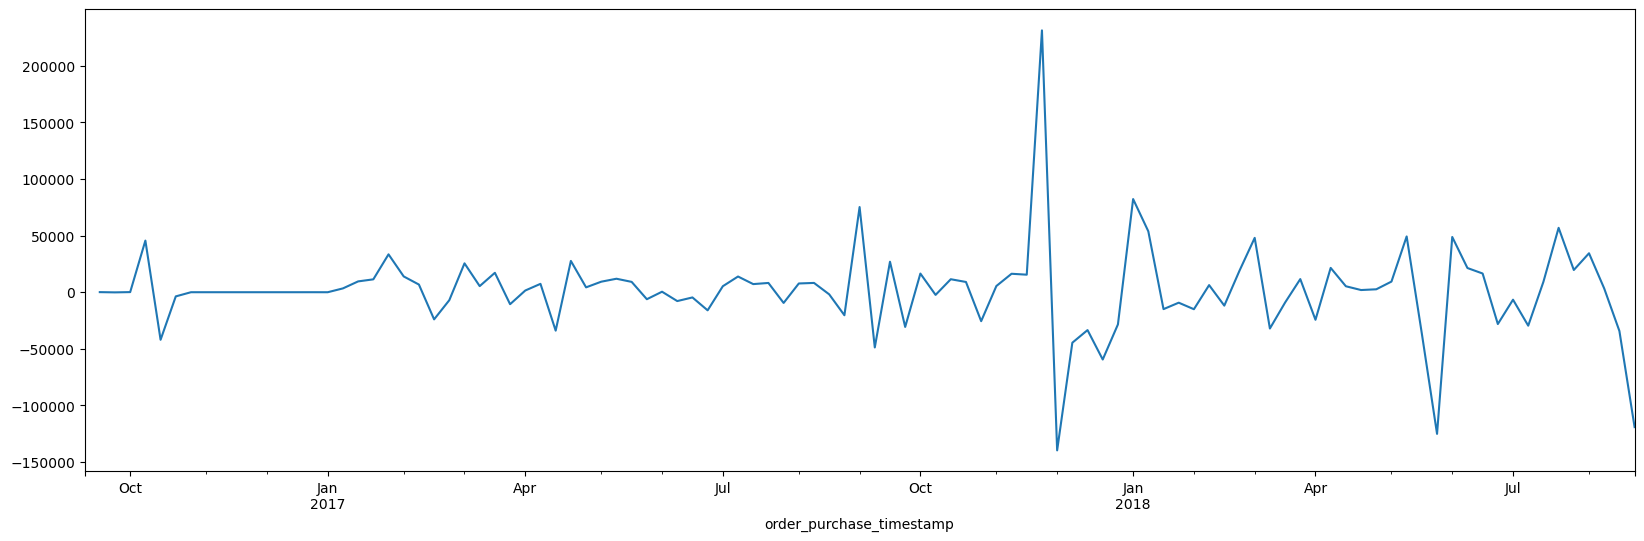

In [66]:
#Making the series stationary
dataTimeMean.price.diff(1).plot(figsize=(20, 6))

<AxesSubplot:xlabel='order_purchase_timestamp'>

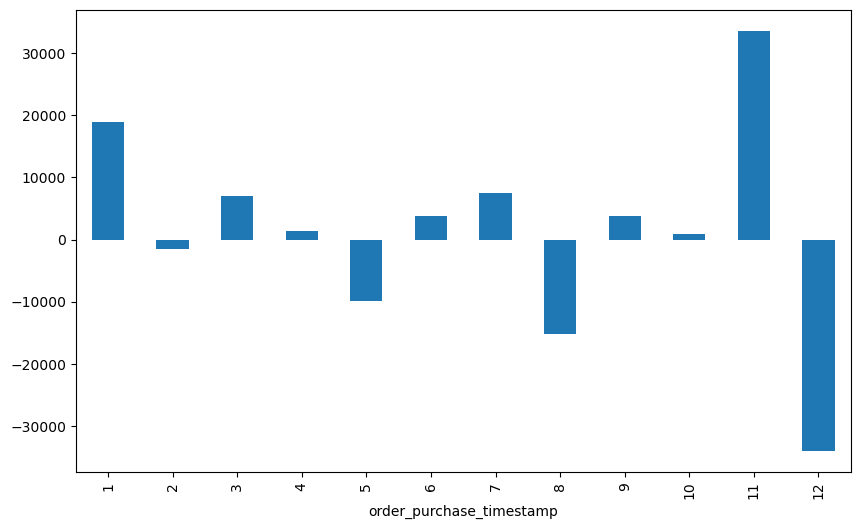

In [67]:
dataTimeMean.price.diff(1).groupby(dataTimeMean.index.month).mean().plot(kind='bar', figsize=(10, 6))

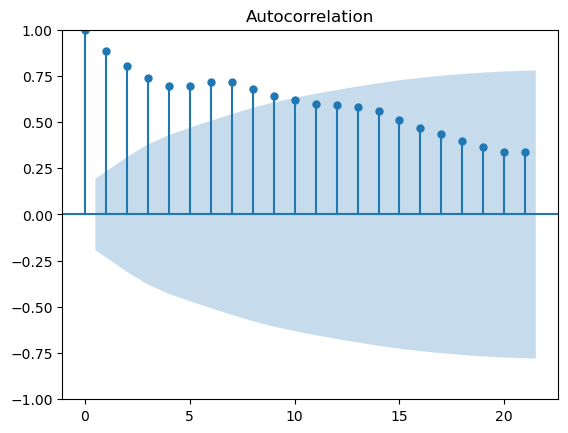

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataTimeMean.price)
plt.show()

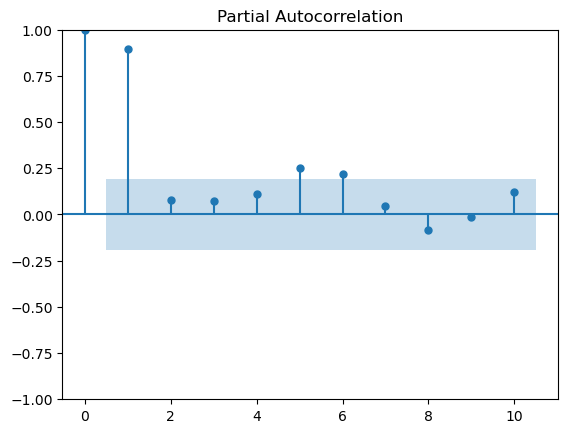

In [69]:
plot_pacf(dataTimeMean.price, lags=10)
plt.show()

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = dataTimeMean[['x1']]
y = dataTimeMean.price.values

linearRegression = LinearRegression().fit(X, y)
predictionsLinear = linearRegression.predict(X)

print('RMSE for Linear Regression was: \n', mean_squared_error(y, predictionsLinear, squared=False))

RMSE for Linear Regression was: 
 38490.3446838845


In [72]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=150, learning_rate=0.05)
xgb.fit(X, y, 
        early_stopping_rounds=5, 
        eval_set=[(X, y)], 
        verbose=False
)

predictions_XGBoost = xgb.predict(X)

print('RMSE for xgb was: \n', mean_squared_error(y, predictions_XGBoost, squared=False))


RMSE for xgb was: 
 6730.11352263392


In [73]:
from sklearn.ensemble import RandomForestRegressor
randomF = RandomForestRegressor(n_estimators = 500, random_state=0).fit(X, y)

predictions_RandomForest = randomF.predict(X)
print('RMSE for Random Forest was: \n', mean_squared_error(y, predictions_RandomForest, squared=False))

RMSE for Random Forest was: 
 16711.08269253004


So, we will choose XGB Regressor.

<AxesSubplot:xlabel='order_purchase_timestamp'>

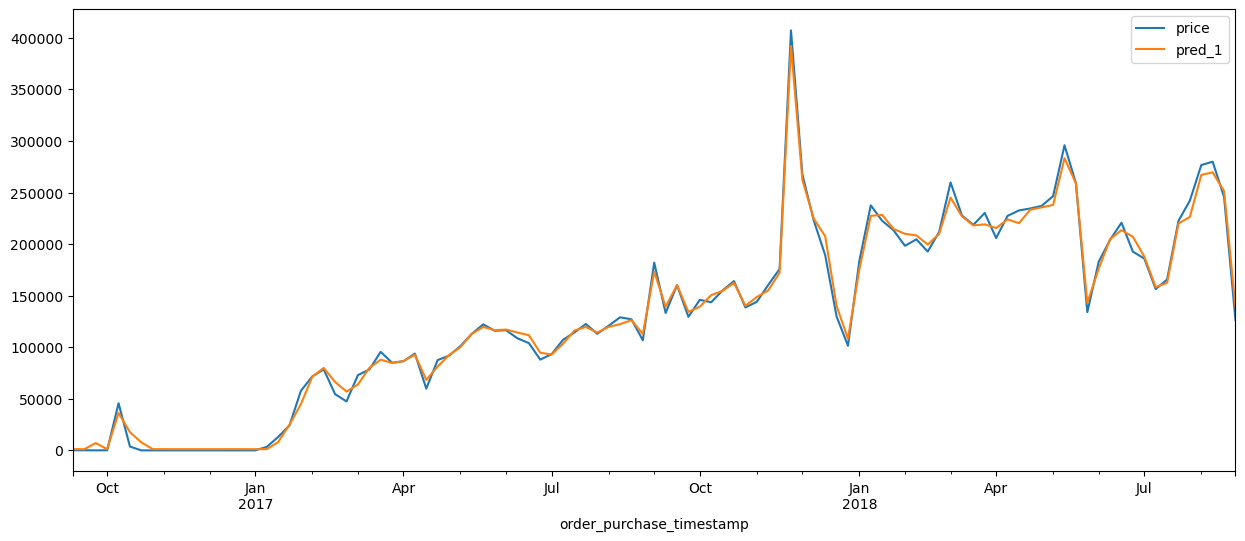

In [74]:
dataTimeMean['pred_1'] = xgb.predict(X)
dataTimeMean[['price', 'pred_1']].plot(figsize=(15, 6))

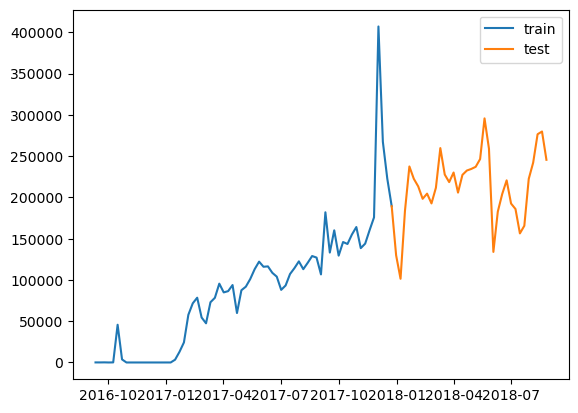

In [75]:
train_size = int(len(dataTimeMean.price) * 2 / 3)

train = X[:train_size]
test = X[train_size-1:]

plt.plot(train)
plt.plot(test)
plt.legend(['train', 'test'])

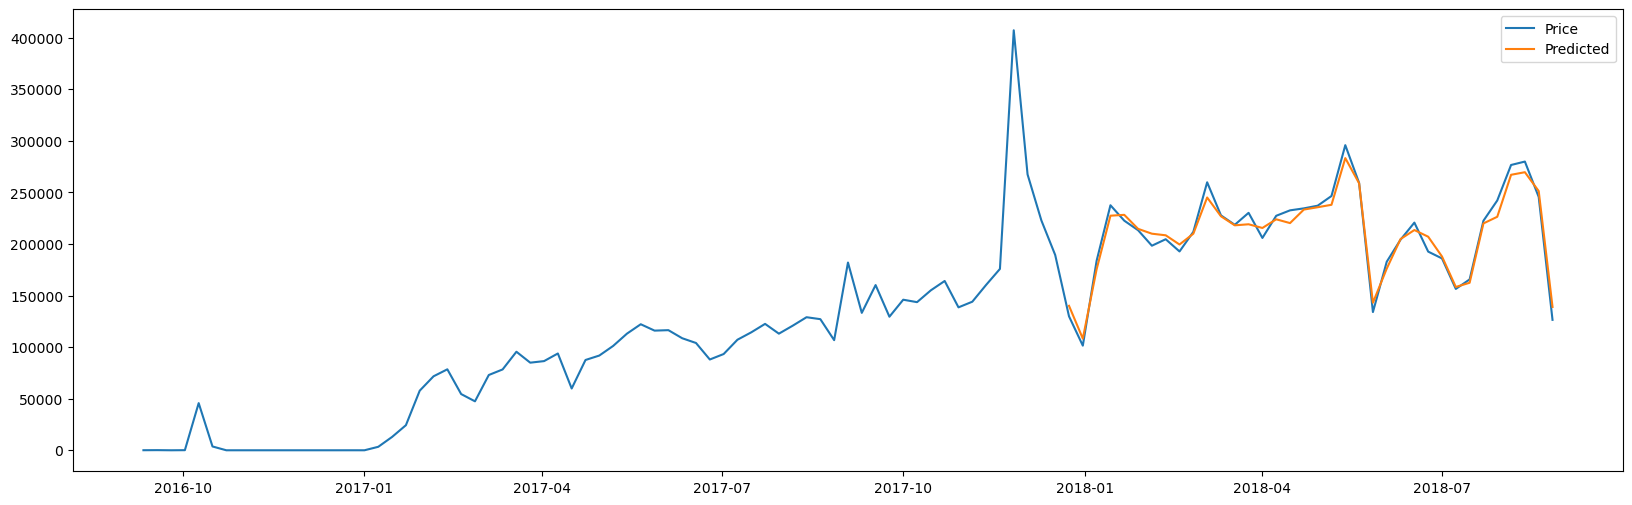

In [76]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.plot(test.index, forecast)
plt.legend(['Price', 'Predicted'])

In [77]:
lastPrice = dataTimeMean['price'][-1]

datesToPredict = pd.Series(dataTimeMean.index[-1] + pd.Timedelta('1 w'))

forecastData =  pd.DataFrame({'x1': str(lastPrice)}, index=datesToPredict)  
forecastData.x1 = pd.to_numeric(forecastData.x1)


print("Next week's predicted price is: R$", xgb.predict(forecastData))

Next week's predicted price is: R$ [114240.76]


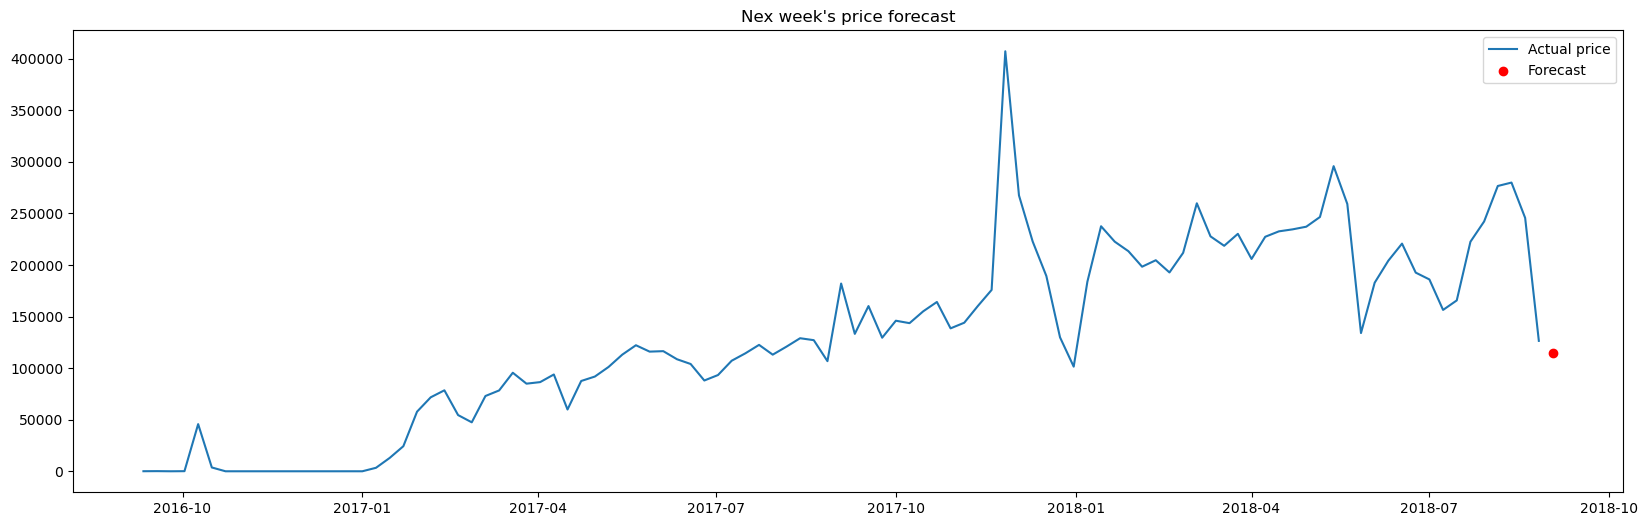

In [78]:
plt.figure(figsize=(20, 6))
plt.plot(dataTimeMean.price)
forecast = xgb.predict(test)
plt.scatter(forecastData.index, xgb.predict(forecastData), color='red')
plt.title("Nex week's price forecast")
plt.legend(['Actual price', 'Forecast'])

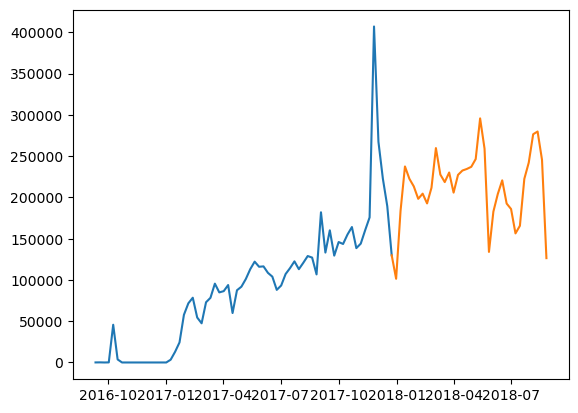

In [79]:
#Delete data generated from XGB
dataTimeMean = dataTimeMean.drop(columns=['pred_1', 'x1'], axis=0)

train = dataTimeMean[:train_size]
test = dataTimeMean[train_size-1:]

plt.plot(train)
plt.plot(test)

In [80]:
autoArimaModel = auto_arima(train, m=12, seazonal=False, 
                            trace=False, random_state=1, n_fits=50)

autoArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -662.105
Date:                            Mon, 20 May 2024   AIC                           1330.211
Time:                                    12:24:18   BIC                           1336.287
Sample:                                09-11-2016   HQIC                          1332.566
                                     - 12-24-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.618e+04   8234.080      1.965      0.049      41.159    3.23e+04
ar.L1          0.6000      0.134      4.489      0.000       0.338       0.862
sigma2      1.104e+09      0.074    1.5e+10      0.000     1.1e+09     1.1e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               277.17
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.76   Skew:                             2.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.33e+28. Standard errors may be unstable.
"""

In [81]:
dateRange = pd.date_range(dataTimeMean.index[-1], freq='W', periods=13)[1:]

predict = pd.DataFrame(autoArimaModel.predict(n_periods=len(dateRange)), index=dateRange)
predict.columns = ['price']
predict.price = predict.price.round(2)

print('Next weeks pridiction from auto-ARIMA')
print(predict.price)

Next weeks pridiction from auto-ARIMA
2018-09-02   NaN
2018-09-09   NaN
2018-09-16   NaN
2018-09-23   NaN
2018-09-30   NaN
2018-10-07   NaN
2018-10-14   NaN
2018-10-21   NaN
2018-10-28   NaN
2018-11-04   NaN
2018-11-11   NaN
2018-11-18   NaN
Freq: W-SUN, Name: price, dtype: float64


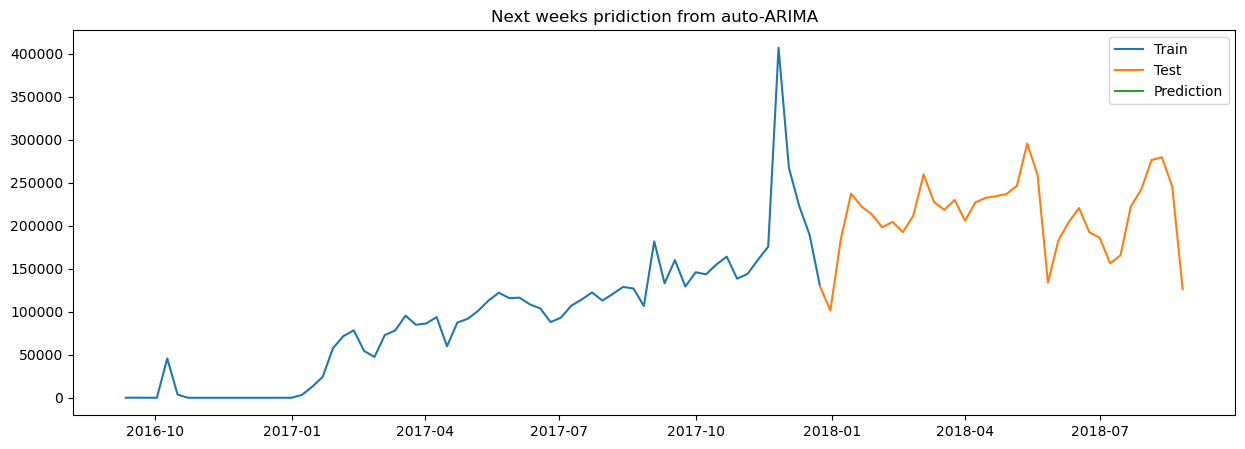

In [82]:
plt.figure(figsize=(15,5))
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.title('Next weeks pridiction from auto-ARIMA')
plt.legend(loc='best')
plt.show()